In [1]:
!pip install torchmetrics

# All the necessary imports

In [2]:
from PIL import Image
from pathlib import Path
from torch import nn
import pathlib
import random
import matplotlib.pyplot as plt
import albumentations as A
import numpy as np
import os
from albumentations.pytorch import ToTensorV2
import cv2

from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as T
import torch.nn.functional as F

import torch
import re

In [3]:
PATH_HACK = Path('/kaggle/input/gagarin/Gagarin Hack multilabel')

In [4]:
# make the system the device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device is {device}')

Using device is cuda


In [5]:
def plot_images(
    image_paths: pathlib.PosixPath,
    n:int = 3,
):
    '''Plot n random samples from each class'''

    for image_path in image_paths:
        images = list(pathlib.Path(image_path).glob('*/'))
        random_image_paths = random.sample(images, k=n)
        fig, ax = plt.subplots(1, n)
        for i, image in enumerate(random_image_paths):
            with Image.open(image) as f:
                ax[i].imshow(f)
                ax[i].axis("off")
                fig.suptitle(f"Class: {image_path.stem}", fontsize=16)

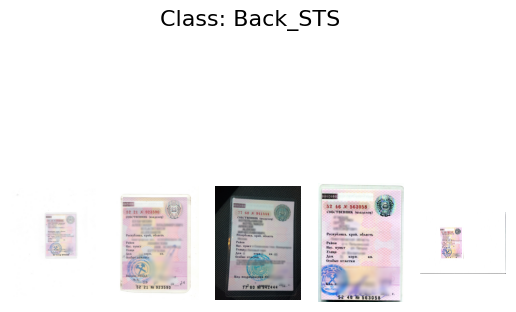

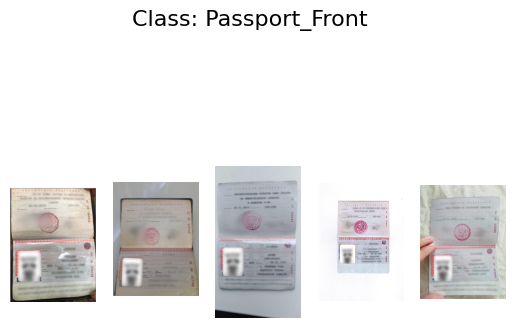

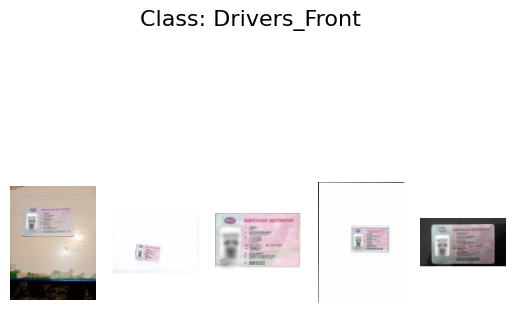

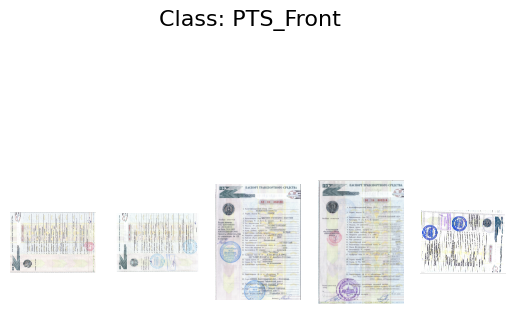

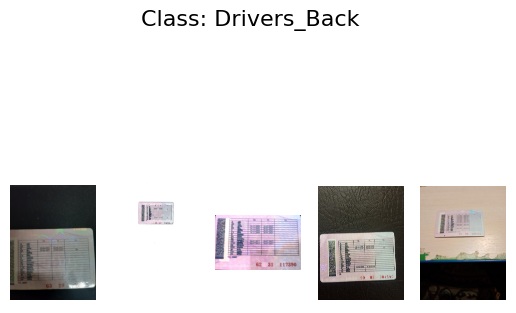

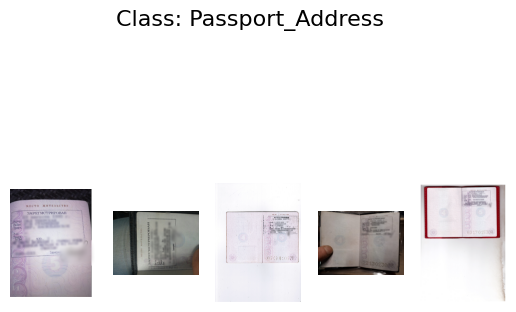

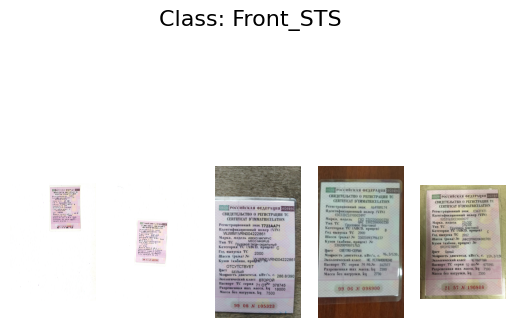

In [6]:
image_path_list=list(PATH_HACK.glob('*/'))
plot_images(image_path_list, n=5)

In [7]:
import torchvision
from torchvision import datasets, transforms

weights = torchvision.models.ResNet50_Weights.DEFAULT
model = torchvision.models.resnet50(weights=weights)
print('The model has succesfully imported')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


The model has succesfully imported


In [8]:
# Implement auto-transformation without data augmentation
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [9]:
print(os.listdir(PATH_HACK))
print(len(os.listdir(PATH_HACK)))

['Back_STS', 'Passport_Front', 'Drivers_Front', 'PTS_Front', 'Drivers_Back', 'Passport_Address', 'Front_STS']
7


In [10]:
classes = ['Passport', 'STS', 'Drivers', 'PTS', 'Back', 'Front', 'Address']

In [11]:
def encode_label(label, classes_list = classes):
    target = torch.zeros(7)
    for l in label:
        idx = classes_list.index(l)
        target[idx] = 1
    return target

def decode_target(target, text_labels=True, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            result.append(classes[i])

    return ' '.join(result)

In [12]:
def get_path_names(dir):
    images = []
    for path, subdirs, files in os.walk(dir):
        for name in files:
            #print(os.path.join(path, name))
            images.append(os.path.join(path, name))
    return images

In [13]:
class myDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)
        label = re.findall(r'\w+\_\w+', img_path)[0].split('_')

        return img, encode_label(label)

In [14]:
class myDataset_Albu(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        # Read an image with OpenCV
        image = cv2.imread(img_path)

        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        label = re.findall(r'\w+\_\w+', img_path)[0].split('_')

        return image, encode_label(label)

In [15]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

transform= T.Compose([T.Resize(244),
                      T.RandomCrop(244),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(2),
                      T.ToTensor(),
                      T.Normalize(*imagenet_stats)])

In [16]:
albu_transform = A.Compose([
    A.LongestMaxSize(400, p=1),
    A.SmallestMaxSize(max_size=400, p=1),
    A.RandomCrop(400, 400),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [17]:
albu_dataset = myDataset_Albu(PATH_HACK, transform = albu_transform)
len(albu_dataset)

430

In [18]:
dataset = myDataset(PATH_HACK, transform = transform)
len(dataset)

430

Label: Drivers Front
tensor([0., 0., 1., 0., 0., 1., 0.])


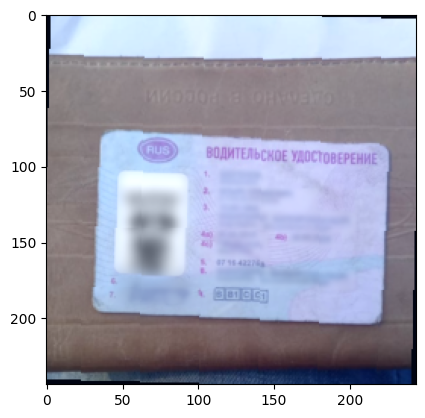

In [19]:
def denorm(img_tensors):
    return img_tensors * imagenet_stats[1][0] + imagenet_stats[0][0]

def show_example(img,label):
    plt.imshow(denorm(img).permute(1,2,0))
    print("Label:", decode_target(label))
    print(label)

i = random.randint(0, len(dataset))
show_example(*dataset[i])

Label: Passport Front
tensor([1., 0., 0., 0., 0., 1., 0.])
torch.Size([400, 400, 3])


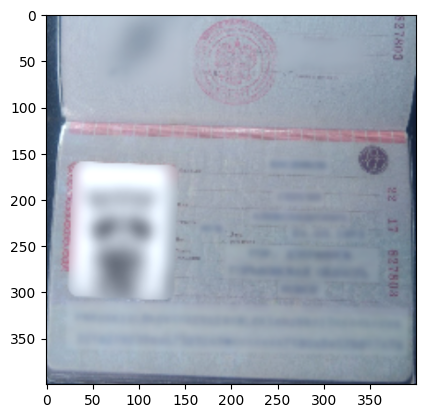

In [20]:
def denorm(img_tensors):
    return img_tensors * imagenet_stats[1][0] + imagenet_stats[0][0]

def show_example(img,label):
    plt.imshow(denorm(img).permute(1,2,0))
    print("Label:", decode_target(label))
    print(label)
    print(denorm(img).permute(1,2,0).shape)

i = random.randint(0, len(dataset))
show_example(*albu_dataset[i])


In [21]:
dataset = albu_dataset

In [22]:
val_percent = int(0.15 * len(dataset))
train_size = len(dataset) - val_percent
val_size = len(dataset) - train_size
train_size, val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(366, 64)

In [23]:
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size=8)
test_dataloader = DataLoader(val_ds, shuffle=False, batch_size=8)

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')    

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device        

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


device = get_default_device()
device

device(type='cuda')

In [25]:
train_dl = DeviceDataLoader(train_dataloader, device)
val_dl = DeviceDataLoader(test_dataloader, device)

In [26]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)


class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                    
        loss = F.binary_cross_entropy(out, targets)     
        return loss    

    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }        

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}

    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [27]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))


    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()


            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]

    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

class ResNet15(MultilabelImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()     
        # input 3 x 128 x 128
        self.conv1 = conv_block(in_channels, 64) 
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64)) # 64 x 128 x 128

        self.conv2 = conv_block(64, 128, pool=True) #128 x 32 x 32
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128), conv_block(128, 128))        

        self.conv3 = conv_block(128, 512, pool=True) #512 x 8 x 8
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.conv4 = conv_block(512, 1024, pool=True) #1024 x 2 x 2
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))

        #self.conv5 = conv_block(1024, 2048, pool=True) #2048 x 8 x 8
        #self.res5 = nn.Sequential(conv_block(2048, 2048), conv_block(2048, 2048))   

        self.classifier = nn.Sequential(nn.MaxPool2d(4), #1024 x 1 x 1
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(1024 * 1 * 1, 512),
                                        nn.ReLU(),
                                        nn.Linear(512, num_classes))        

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.conv4(out)
        out = self.res4(out) + out
        #out = self.conv5(out)
        #out = self.res5(out) + out
        out = self.classifier(out)
        out = F.sigmoid(out)
        return out

In [29]:
tensor = albu_dataset[0][0].unsqueeze(0)
tensor.shape
b1 = conv_block(3, 64)
r1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
b2 = conv_block(64, 128, pool=True)
r2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128), conv_block(128, 128))   
b3 = conv_block(128, 512, pool=True) #512 x 8 x 8
r3= nn.Sequential(conv_block(512, 512), conv_block(512, 512))
b4 = conv_block(512, 1024, pool=True) #1024 x 2 x 2
r4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))
clas = nn.Sequential(nn.MaxPool2d(4), #1024 x 1 x 1
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(1024 * 1 * 1, 512),
                                        nn.ReLU(),
                                        nn.Linear(512, 7) 
                                        )      
print(b1(tensor).shape)
c = r4(b4(r3(b3(r2(b2(r1(b1(tensor))))))))
print(r4(b4(r3(b3(r2(b2(r1(b1(tensor)))))))).shape)
print(clas(c).shape)

torch.Size([1, 64, 400, 400])
torch.Size([1, 1024, 6, 6])
torch.Size([1, 7])


In [30]:
model = to_device(ResNet15(3, len(classes)), device)
model

ResNet15(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=Fa

In [31]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.6910021305084229, 'val_score': 0.44982433319091797}]

In [32]:
epochs = 30
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [33]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.0001, train_loss: 0.5616, val_loss: 0.5582, val_score: 0.2682


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0002, train_loss: 0.4613, val_loss: 0.4716, val_score: 0.5577


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0003, train_loss: 0.4108, val_loss: 0.4916, val_score: 0.5287


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.0004, train_loss: 0.3942, val_loss: 0.6320, val_score: 0.5778


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.0006, train_loss: 0.3884, val_loss: 0.4071, val_score: 0.5919


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.0008, train_loss: 0.3733, val_loss: 0.3105, val_score: 0.7333


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.0009, train_loss: 0.3004, val_loss: 0.3673, val_score: 0.6529


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.0010, train_loss: 0.3169, val_loss: 0.7046, val_score: 0.5838


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.0010, train_loss: 0.2524, val_loss: 0.1991, val_score: 0.8143


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.0010, train_loss: 0.2314, val_loss: 0.1885, val_score: 0.8556


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.0010, train_loss: 0.2130, val_loss: 0.2221, val_score: 0.8037


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.0010, train_loss: 0.1676, val_loss: 0.1988, val_score: 0.8103


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.0009, train_loss: 0.1960, val_loss: 0.1398, val_score: 0.8709


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.0009, train_loss: 0.1411, val_loss: 0.1824, val_score: 0.8433


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.0008, train_loss: 0.1333, val_loss: 0.1003, val_score: 0.9244


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.0008, train_loss: 0.1496, val_loss: 0.1583, val_score: 0.8802


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.0007, train_loss: 0.1080, val_loss: 0.1205, val_score: 0.8826


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.0006, train_loss: 0.0895, val_loss: 0.1566, val_score: 0.8857


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.0005, train_loss: 0.1060, val_loss: 0.1060, val_score: 0.9295


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.0005, train_loss: 0.0783, val_loss: 0.0426, val_score: 0.9688


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.0004, train_loss: 0.0629, val_loss: 0.0623, val_score: 0.9553


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.0003, train_loss: 0.0525, val_loss: 0.0818, val_score: 0.9112


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.0003, train_loss: 0.0509, val_loss: 0.0565, val_score: 0.9427


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.0002, train_loss: 0.0441, val_loss: 0.0494, val_score: 0.9622


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.0001, train_loss: 0.0498, val_loss: 0.0534, val_score: 0.9604


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.0001, train_loss: 0.0331, val_loss: 0.0622, val_score: 0.9502


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.0000, train_loss: 0.0453, val_loss: 0.0583, val_score: 0.9427


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.0000, train_loss: 0.0222, val_loss: 0.0598, val_score: 0.9297


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.0000, train_loss: 0.0334, val_loss: 0.0835, val_score: 0.9257


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.0000, train_loss: 0.0282, val_loss: 0.0979, val_score: 0.9335
CPU times: user 24min 34s, sys: 1min 12s, total: 25min 47s
Wall time: 23min 18s


In [34]:
def predict_single(image):
    #xb = image.unsqueeze(0)
    xb = to_device(image.unsqueeze(0), device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction Tensor: ", prediction)
    print()
    show_example(image, prediction)

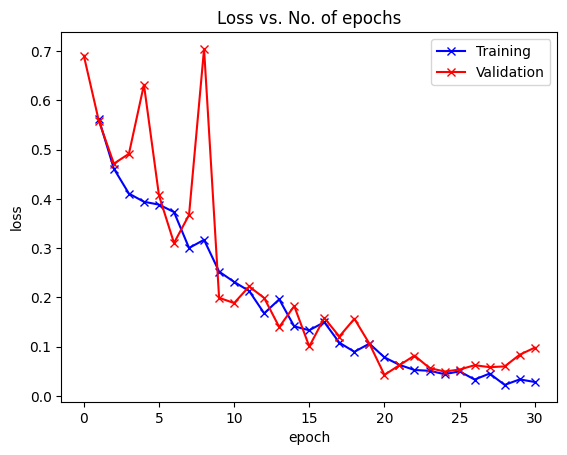

In [35]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

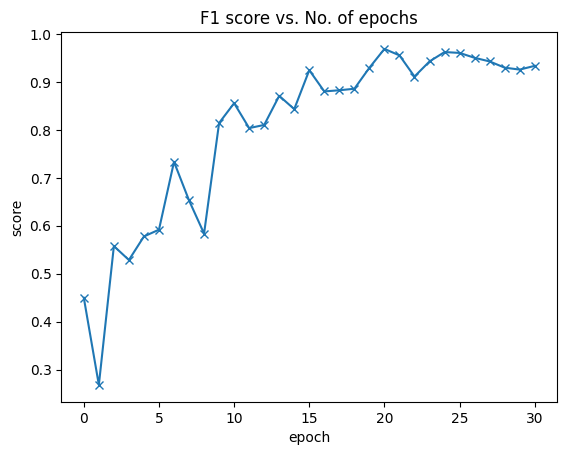

In [36]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');
plot_scores(history)

In [37]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction Tensor: ", prediction)
    print()
    show_example(image, prediction)

Prediction Tensor:  tensor([3.4459e-04, 9.9667e-01, 1.5002e-03, 1.9749e-03, 9.8797e-03, 9.9014e-01,
        8.8779e-05], device='cuda:0', grad_fn=<SelectBackward0>)

Label: STS Front
tensor([3.4459e-04, 9.9667e-01, 1.5002e-03, 1.9749e-03, 9.8797e-03, 9.9014e-01,
        8.8779e-05], device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([400, 400, 3])


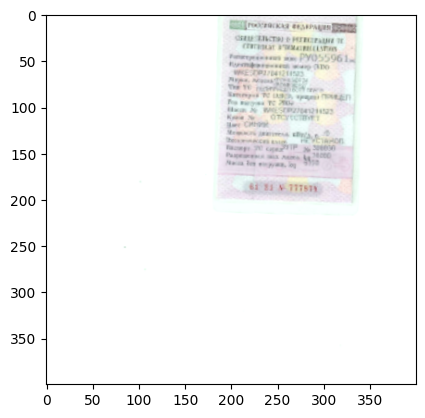

In [38]:
i = random.randint(0, len(val_ds))
predict_single(val_ds[i][0])

In [39]:
MODEL_PATH = Path('/kaggle/working/models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = 'ResNet15Torch.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model parameters to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model parameters to: /kaggle/working/models/ResNet15Torch.pth
